# **CIFAR-10 Object Recognition using SVM and CNN**


In this notebook we implement two machine learning approaches for classifying images from the CIFAR-10 dataset:
1. Support Vector Machine (SVM) with Histogram of Oriented Gradients (HOG) features and PCA
2. Convolutional Neural Network (CNN)

In [184]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import tensorflow as tf
import skimage.feature
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from skimage import color, feature
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### **Analysing data**

The data is structured as 4D arrays: (height, width, channels, samples)

In [185]:
training_image = np.load('trnImage.npy')
training_label = np.load('trnLabel.npy')
testing_image = np.load('tstImage.npy')
testing_label = np.load('tstLabel.npy')

In [186]:
# analysing data
print(f"Training images shape = {training_image.shape}")
print(f"Training labels shape = {training_label.shape}")
print(f"Testing labels shape = {testing_label.shape}")
print(f"Testing images shape = {testing_image.shape}")

Training images shape = (32, 32, 3, 10000)
Training labels shape = (10000, 1)
Testing labels shape = (1000, 1)
Testing images shape = (32, 32, 3, 1000)


In [187]:
# reshaping data
training_image = np.transpose(training_image, (3, 0, 1, 2))
testing_image  = np.transpose(testing_image,  (3, 0, 1, 2))

In [188]:
# converting images to gray scale before HOG extraction
image_index = 1
image = training_image[image_index]
gray = color.rgb2gray(image)

hog, hog_image = feature.hog(
    gray,
    pixels_per_cell = (3, 3),
    cells_per_block = (2, 2),
    visualize = True
)


### **Extracting Hog Features**

This converts each 32×32×3 image into a 1D feature vector that captures shape and edge information.

In [189]:
# converting images to hog images
def hog_features(images):
    hog_list = []
    for img in images:
        gray = color.rgb2gray(img)
        hog = feature.hog(gray, pixels_per_cell=(3, 3), cells_per_block=(2, 2), visualize=False)
        hog_list.append(hog)
    return np.array(hog_list)

training_img_hog = hog_features(training_image)
testing_img_hog  = hog_features(testing_image)



### **Visualising Hog Features**

Visualizing HOG features for a sample image to understand what information is being extracted.

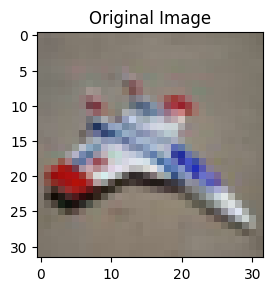

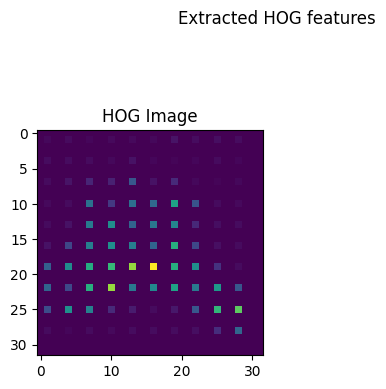

In [190]:
# visualising
plt.subplot(122)
plt.imshow(image)
plt.title('Original Image')
plt.figure()
plt.subplot(121)
plt.imshow(hog_image)
plt.title('HOG Image')
plt.suptitle(f'Extracted HOG features')
plt.show(block=False)

### **Standardisation**

Standardizing the HOG features to have zero mean and unit variance.
This is crucial for SVM as it is sensitive to feature scales.

In [191]:
standardisation = StandardScaler()
training_image_standardised = standardisation.fit_transform(training_img_hog)
testing_image_standardised = standardisation.transform(testing_img_hog)


### **Dimensionality Reduction with Principal Component Analysis**

Applying Principal Component Analysis (PCA) to reduce the feature dimensionality to 300 components.




In [192]:
n_components = 300
pca = PCA(n_components = n_components)
training_image_pca = pca.fit_transform(training_image_standardised)
testing_image_pca = pca.transform(testing_image_standardised)
print(f"Training features shape: {training_image_pca.shape}")
print(f"Testing features shape: {testing_image_pca.shape}")

Training features shape: (10000, 300)
Testing features shape: (1000, 300)


### **Training SVM classifier**

In [193]:
svm_classifier = SVC(kernel = 'rbf', C = 10, gamma = 0.001)
svm_classifier.fit(training_image_standardised, training_label)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10, gamma=0.001)

### **SVM Predictions and Evaluation**

Generating predictions on the test set and evaluating performance using:
- Accuracy score
- Classification report (precision, recall, F1-score per class)

In [194]:
# calculating accuracy
testing_label_subset = np.asarray(testing_label).reshape(-1).astype(int)
training_subset = testing_image_standardised[: testing_label_subset.shape[0],:]

print("Using subset size:", testing_label_subset.shape[0])
y_pred_subset = svm_classifier.predict(training_subset)
print(f"SVM  Accuracy : ", accuracy_score(testing_label_subset, y_pred_subset)*100)

#classification report
print(classification_report(testing_label, y_pred_subset))



Using subset size: 1000
SVM  Accuracy :  47.3
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       100
           1       0.60      0.49      0.54       100
           2       0.31      0.25      0.28       100
           3       0.38      0.42      0.40       100
           4       0.40      0.53      0.46       100
           5       0.41      0.50      0.45       100
           6       0.55      0.56      0.56       100
           7       0.70      0.47      0.56       100
           8       0.45      0.50      0.48       100
           9       0.56      0.48      0.52       100

    accuracy                           0.47      1000
   macro avg       0.49      0.47      0.47      1000
weighted avg       0.49      0.47      0.47      1000



### **Confusion Matrix**

Visualizing the confusion matrix to understand which classes are being confused with each other

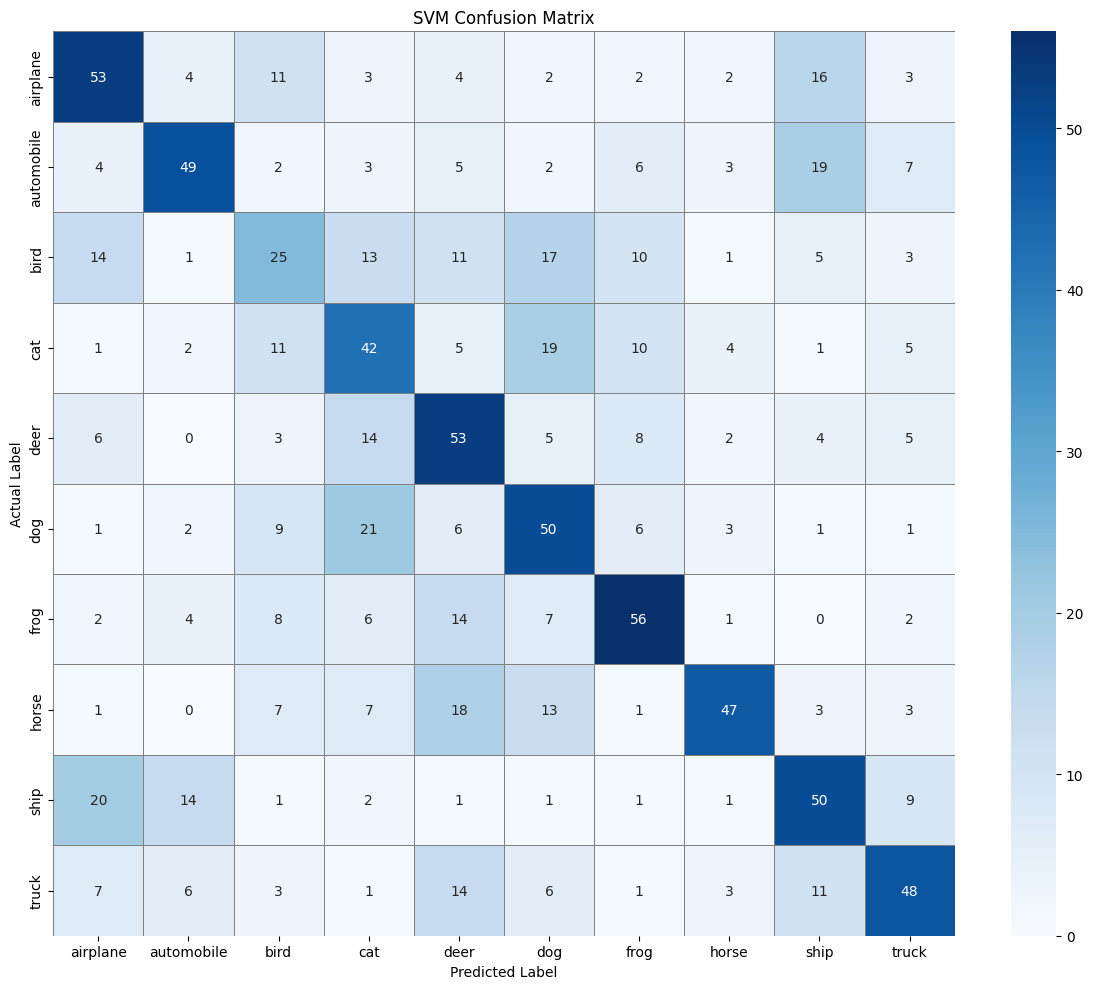

In [195]:

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Compute confusion matrix
cm = confusion_matrix(testing_label_subset, y_pred_subset)

plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            linewidths=0.5,
            linecolor='gray')

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('SVM Confusion Matrix')
plt.tight_layout()
plt.show()


## **Convolutional Neural Network (CNN) Classification**

### **Normalize Image Data**

Normalize pixel values from [0, 255] to [0, 1] range.

In [196]:
training_image = training_image.astype('float32') / 255.0
testing_image  = testing_image.astype('float32')  / 255.0


### **Defining CNN Architecture**


In [197]:
def cnn_model(input_shape=(32, 32, 3), num_classes=10):

    model = keras.Sequential([

        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


cnn_model = cnn_model(input_shape=(32, 32, 3), num_classes = 10)

# compile the model
cnn_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss ='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [204]:
# training the CNN
history = cnn_model.fit(
    training_image, training_label,
    batch_size = 32,
    epochs = 20,
    validation_split = 0.1,
    verbose = 1
)


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 96s 339ms/step - accuracy: 0.5873 - loss: 1.1525 - val_accuracy: 0.0000e+00 - val_loss: 7.5558
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 92s 328ms/step - accuracy: 0.6213 - loss: 1.0560 - val_accuracy: 0.0000e+00 - val_loss: 8.0193
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 140s 323ms/step - accuracy: 0.6487 - loss: 0.9786 - val_accuracy: 0.0000e+00 - val_loss: 7.6389
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 93s 331ms/step - accuracy: 0.6721 - loss: 0.9324 - val_accuracy: 0.0000e+00 - val_loss: 7.0686
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 90s 320ms/step - accuracy: 0.6984 - loss: 0.8680 - val_accuracy: 0.0000e+00 - val_loss: 8.4967
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 142s 320ms/step - accuracy: 0.7084 - loss: 0.8352 - val_accuracy: 0.0000e+00 - val_loss: 9.0819
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 90s 321ms/step - accuracy: 0.7233 - loss: 0.7723 - val_accuracy: 0.0000e+00 - val_loss: 8.1291
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 92s 326ms/ste

### **Evaluating CNN on Test Set**

In [205]:

test_loss, test_accuracy = cnn_model.evaluate(testing_image, testing_label, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5922 - loss: 1.5296
Test Accuracy: 55.30%
Test Loss: 2.3036


### **CNN Confusion Matrix**

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


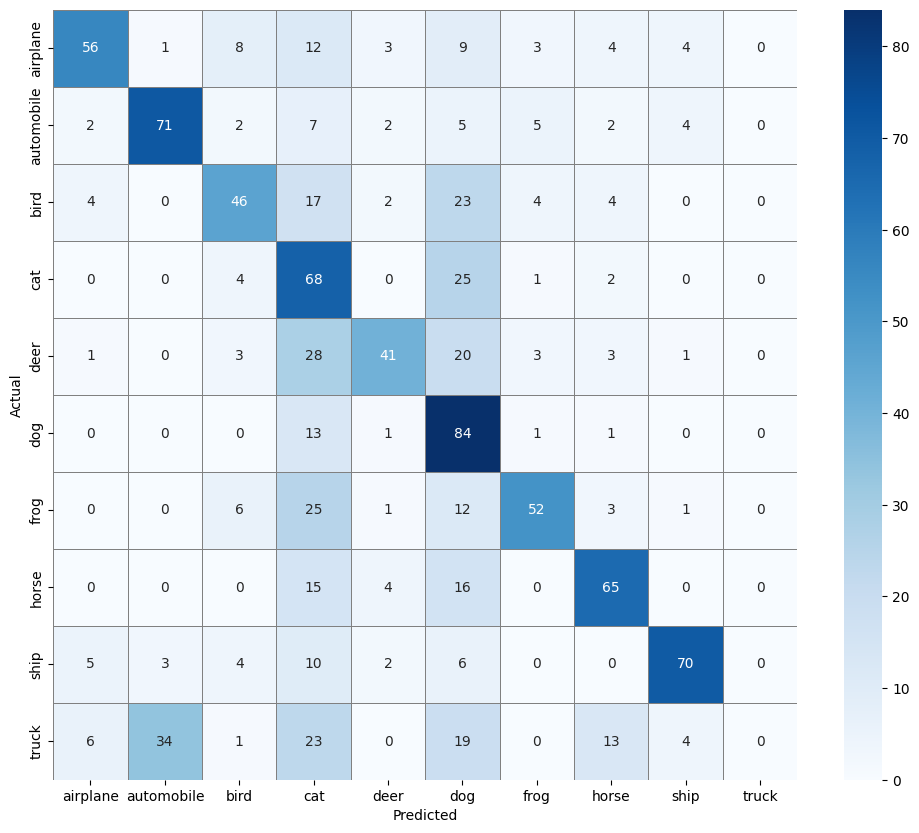

In [206]:
y_pred_probs = cnn_model.predict(testing_image)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(testing_label.reshape(-1), y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            linewidths=0.5,
            linecolor='gray')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [207]:
# creating classification report
print(classification_report(testing_label, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.56      0.64       100
           1       0.65      0.71      0.68       100
           2       0.62      0.46      0.53       100
           3       0.31      0.68      0.43       100
           4       0.73      0.41      0.53       100
           5       0.38      0.84      0.53       100
           6       0.75      0.52      0.62       100
           7       0.67      0.65      0.66       100
           8       0.83      0.70      0.76       100
           9       0.00      0.00      0.00       100

    accuracy                           0.55      1000
   macro avg       0.57      0.55      0.54      1000
weighted avg       0.57      0.55      0.54      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Performance Comparison:**

| Model | Test Accuracy | Key Strengths |
|-------|---------------|---------------|
| SVM | 47.30% | Fast training, interpretable features, good on horses |
| CNN | 55.00% | Better overall performance, learns features automatically |

### Key Findings:

- CNN outperforms SVM
- Both models struggle with similar animal categories (bird, cat, dog)
- CNN shows particular strength on ships (83% precision) and airplanes (76% precision)
- SVM performs better on horses (70% precision) compared to CNN (67% precision)
- CNN completely fails on truck classification (0% across all metrics), indicating a significant issue

### Improvements for Future Work:
1. Train CNN for more epochs (50-100) with early stopping.
2. Implement data augmentation (flips, rotations, shifts).
3. Perform hyperparameter optimization for both models
4. Investigate the truck classification failure in CNN